In [98]:
import networkx as nx
import matplotlib.pyplot as plt

In [110]:
"""Modularity matrix of graphs.
"""
#    Copyright (C) 2004-2015 by
#    Aric Hagberg <hagberg@lanl.gov>
#    Dan Schult <dschult@colgate.edu>
#    Pieter Swart <swart@lanl.gov>
#    All rights reserved.
#    BSD license.
from __future__ import division
import networkx as nx
from networkx.utils import not_implemented_for
__author__ = "\n".join(['Aric Hagberg <aric.hagberg@gmail.com>',
                        'Pieter Swart (swart@lanl.gov)',
                        'Dan Schult (dschult@colgate.edu)',
                        'Jean-Gabriel Young (Jean.gabriel.young@gmail.com)'])
__all__ = ['modularity_matrix', 'directed_modularity_matrix']


@not_implemented_for('directed')
@not_implemented_for('multigraph')
def modularity_matrix(G, nodelist=None):
    """Return the modularity matrix of G.

    The modularity matrix is the matrix B = A - <A>, where A is the adjacency
    matrix and <A> is the average adjacency matrix, assuming that the graph
    is described by the configuration model.

    More specifically, the element B_ij of B is defined as
        A_ij - k_i k_j/m
    where k_i(in) is the degree of node i, and were m is the number of edges
    in the graph.

    Parameters
    ----------
    G : Graph
       A NetworkX graph

    nodelist : list, optional
       The rows and columns are ordered according to the nodes in nodelist.
       If nodelist is None, then the ordering is produced by G.nodes().

    Returns
    -------
    B : Numpy matrix
      The modularity matrix of G.

    Examples
    --------
    >>> import networkx as nx
    >>> k =[3, 2, 2, 1, 0]
    >>> G = nx.havel_hakimi_graph(k)
    >>> B = nx.modularity_matrix(G)


    See Also
    --------
    to_numpy_matrix
    adjacency_matrix
    laplacian_matrix
    directed_modularity_matrix

    References
    ----------
    .. [1] M. E. J. Newman, "Modularity and community structure in networks",
       Proc. Natl. Acad. Sci. USA, vol. 103, pp. 8577-8582, 2006.
    """
    if nodelist is None:
        nodelist = G.nodes()
    A = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, format='csr')
    k = A.sum(axis=1)
    m = G.number_of_edges()
    # Expected adjacency matrix
    X = k * k.transpose() / (2 * m)
    return A - X


@not_implemented_for('undirected')
@not_implemented_for('multigraph')
def directed_modularity_matrix(G, nodelist=None):
    """Return the directed modularity matrix of G.

    The modularity matrix is the matrix B = A - <A>, where A is the adjacency
    matrix and <A> is the expected adjacency matrix, assuming that the graph
    is described by the configuration model.

    More specifically, the element B_ij of B is defined as
        B_ij = A_ij - k_i(out) k_j(in)/m
    where k_i(in) is the in degree of node i, and k_j(out) is the out degree
    of node j, with m the number of edges in the graph.

    Parameters
    ----------
    G : DiGraph
       A NetworkX DiGraph

    nodelist : list, optional
       The rows and columns are ordered according to the nodes in nodelist.
       If nodelist is None, then the ordering is produced by G.nodes().

    Returns
    -------
    B : Numpy matrix
      The modularity matrix of G.

    Examples
    --------
    >>> import networkx as nx
    >>> G = nx.DiGraph()
    >>> G.add_edges_from(((1,2), (1,3), (3,1), (3,2), (3,5), (4,5), (4,6),
    ...                   (5,4), (5,6), (6,4)))
    >>> B = nx.directed_modularity_matrix(G)


    Notes
    -----
    NetworkX defines the element A_ij of the adjacency matrix as 1 if there
    is a link going from node i to node j. Leicht and Newman use the opposite
    definition. This explains the different expression for B_ij.

    See Also
    --------
    to_numpy_matrix
    adjacency_matrix
    laplacian_matrix
    modularity_matrix

    References
    ----------
    .. [1] E. A. Leicht, M. E. J. Newman, 
       "Community structure in directed networks",
        Phys. Rev Lett., vol. 100, no. 11, p. 118703, 2008.
    """
    if nodelist is None:
        nodelist = G.nodes()
    A = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, format='csr')
    k_in = A.sum(axis=0)
    k_out = A.sum(axis=1)
    m = G.number_of_edges()
    # Expected adjacency matrix
    X = k_out * k_in / m
    return A - X


# fixture for nose tests
def setup_module(module):
    from nose import SkipTest
    try:
        import numpy
        import scipy
    except:
        raise SkipTest("NumPy not available")

In [111]:
# -*- coding: utf-8 -*-
# centrality.py - functions for computing communities using centrality notions
#
# Copyright 2015, 2016 NetworkX developers.
#
# This file is part of NetworkX.
#
# NetworkX is distributed under a BSD license; see LICENSE.txt for more
# information.
"""Functions for computing communities based on centrality notions."""

import networkx as nx

def girvan_newman(G, most_valuable_edge=None):

    # If the graph is already empty, simply return its connected
    # components.
    if G.number_of_edges() == 0:
        yield tuple(nx.connected_components(G))
        return
    # If no function is provided for computing the most valuable edge,
    # use the edge betweenness centrality.
    if most_valuable_edge is None:
        def most_valuable_edge(G):
            """Returns the edge with the highest betweenness centrality
            in the graph `G`.

            """
            # We have guaranteed that the graph is non-empty, so this
            # dictionary will never be empty.
            betweenness = nx.edge_betweenness_centrality(G)
            return max(betweenness, key=betweenness.get)
    # The copy of G here must include the edge weight data.
    g = G.copy().to_undirected()
    # Self-loops must be removed because their removal has no effect on
    # the connected components of the graph.
    g.remove_edges_from(g.selfloop_edges())
    while g.number_of_edges() > 0:
        yield _without_most_central_edges(g, most_valuable_edge)



def _without_most_central_edges(G, most_valuable_edge):
    """Returns the connected components of the graph that results from
    repeatedly removing the most "valuable" edge in the graph.

    `G` must be a non-empty graph. This function modifies the graph `G`
    in-place; that is, it removes edges on the graph `G`.

    `most_valuable_edge` is a function that takes the graph `G` as input
    (or a subgraph with one or more edges of `G` removed) and returns an
    edge. That edge will be removed and this process will be repeated
    until the number of connected components in the graph increases.

    """
    original_num_components = nx.number_connected_components(G)
    num_new_components = original_num_components
    while num_new_components <= original_num_components:
        edge = most_valuable_edge(G)
        G.remove_edge(*edge)
        new_components = tuple(nx.connected_components(G))
        num_new_components = len(new_components)
    return new_components

In [112]:
"""
*****
Pajek
*****
Read graphs in Pajek format.

This implementation handles directed and undirected graphs including
those with self loops and parallel edges.

Format
------
See http://vlado.fmf.uni-lj.si/pub/networks/pajek/doc/draweps.htm
for format information.
"""
#    Copyright (C) 2008-2014 by
#    Aric Hagberg <hagberg@lanl.gov>
#    Dan Schult <dschult@colgate.edu>
#    Pieter Swart <swart@lanl.gov>
#    All rights reserved.
#    BSD license.
import networkx as nx
from networkx.utils import is_string_like, open_file, make_str
__author__ = """Aric Hagberg <aric.hagberg@gmail.com>"""
__all__ = ['read_pajek', 'parse_pajek', 'generate_pajek', 'write_pajek']

def generate_pajek(G):
    """Generate lines in Pajek graph format.

    Parameters
    ----------
    G : graph
       A Networkx graph

    References
    ----------
    See http://vlado.fmf.uni-lj.si/pub/networks/pajek/doc/draweps.htm
    for format information.
    """
    if G.name=='':
       name='NetworkX'
    else:
       name=G.name
    # Apparently many Pajek format readers can't process this line
    # So we'll leave it out for now.
    # yield '*network %s'%name

    # write nodes with attributes
    yield '*vertices %s'%(G.order())
    nodes = G.nodes()
    # make dictionary mapping nodes to integers
    nodenumber=dict(zip(nodes,range(1,len(nodes)+1)))
    for n in nodes:
        na=G.node.get(n,{})
        x=na.get('x',0.0)
        y=na.get('y',0.0)
        id=int(na.get('id',nodenumber[n]))
        nodenumber[n]=id
        shape=na.get('shape','ellipse')
        s=' '.join(map(make_qstr,(id,n,x,y,shape)))
        for k,v in na.items():
            s+=' %s %s'%(make_qstr(k),make_qstr(v))
        yield s

    # write edges with attributes
    if G.is_directed():
        yield '*arcs'
    else:
        yield '*edges'
    for u,v,edgedata in G.edges(data=True):
        d=edgedata.copy()
        value=d.pop('weight',1.0) # use 1 as default edge value
        s=' '.join(map(make_qstr,(nodenumber[u],nodenumber[v],value)))
        for k,v in d.items():
            s+=' %s %s'%(make_qstr(k),make_qstr(v))
            s+=' %s %s'%(k,v)
        yield s

@open_file(1,mode='wb')
def write_pajek(G, path, encoding='UTF-8'):
    """Write graph in Pajek format to path.

    Parameters
    ----------
    G : graph
       A Networkx graph
    path : file or string
       File or filename to write.
       Filenames ending in .gz or .bz2 will be compressed.

    Examples
    --------
    >>> G=nx.path_graph(4)
    >>> nx.write_pajek(G, "test.net")

    References
    ----------
    See http://vlado.fmf.uni-lj.si/pub/networks/pajek/doc/draweps.htm
    for format information.
    """
    for line in generate_pajek(G):
        line+='\n'
        path.write(line.encode(encoding))

@open_file(0, mode='rb')
def read_pajek(path, encoding='UTF-8'):
    """Read graph in Pajek format from path.

    Parameters
    ----------
    path : file or string
       File or filename to write.
       Filenames ending in .gz or .bz2 will be uncompressed.

    Returns
    -------
    G : NetworkX MultiGraph or MultiDiGraph.

    Examples
    --------
    >>> G=nx.path_graph(4)
    >>> nx.write_pajek(G, "test.net")
    >>> G=nx.read_pajek("test.net")

    To create a Graph instead of a MultiGraph use

    >>> G1=nx.Graph(G)

    References
    ----------
    See http://vlado.fmf.uni-lj.si/pub/networks/pajek/doc/draweps.htm
    for format information.
    """
    lines = (line.decode(encoding) for line in path)
    return parse_pajek(lines)

def parse_pajek(lines):
    """Parse Pajek format graph from string or iterable.

    Parameters
    ----------
    lines : string or iterable
       Data in Pajek format.

    Returns
    -------
    G : NetworkX graph

    See Also
    --------
    read_pajek()

    """
    import shlex
    # multigraph=False
    if is_string_like(lines): lines=iter(lines.split('\n'))
    lines = iter([line.rstrip('\n') for line in lines])
    G=nx.MultiDiGraph() # are multiedges allowed in Pajek? assume yes
    while lines:
        try:
            l=next(lines)
        except: #EOF
            break
        if l.lower().startswith("*network"):
            try:
                label, name = l.split()
            except ValueError:
                # Line was not of the form:  *network NAME
                pass
            else:
                G.graph['name'] = name
        elif l.lower().startswith("*vertices"):
            nodelabels={}
            l,nnodes=l.split()
            for i in range(int(nnodes)):
                l = next(lines)
                try:
                    splitline=[x.decode('utf-8') for x in
                           shlex.split(make_str(l).encode('utf-8'))]
                except AttributeError:
                    splitline = shlex.split(str(l))
                id,label=splitline[0:2]
                G.add_node(label)
                nodelabels[id]=label
                G.node[label]={'id':id}
                try:
                    x,y,shape=splitline[2:5]
                    G.node[label].update({'x':float(x),
                                          'y':float(y),
                                          'shape':shape})
                except:
                    pass
                extra_attr=zip(splitline[5::2],splitline[6::2])
                G.node[label].update(extra_attr)
        elif l.lower().startswith("*edges") or l.lower().startswith("*arcs"):
            if l.lower().startswith("*edge"):
               # switch from multidigraph to multigraph
                G=nx.MultiGraph(G)
            if l.lower().startswith("*arcs"):
               # switch to directed with multiple arcs for each existing edge
                G=G.to_directed()
            for l in lines:
                try:
                    splitline = [x.decode('utf-8') for x in
                                 shlex.split(make_str(l).encode('utf-8'))]
                except AttributeError:
                    splitline = shlex.split(str(l))

                if len(splitline)<2:
                    continue
                ui,vi=splitline[0:2]
                u=nodelabels.get(ui,ui)
                v=nodelabels.get(vi,vi)
                # parse the data attached to this edge and put in a dictionary
                edge_data={}
                try:
                    # there should always be a single value on the edge?
                    w=splitline[2:3]
                    edge_data.update({'weight':float(w[0])})
                except:
                    pass
                    # if there isn't, just assign a 1
#                    edge_data.update({'value':1})
                extra_attr=zip(splitline[3::2],splitline[4::2])
                edge_data.update(extra_attr)
                # if G.has_edge(u,v):
                #     multigraph=True
                G.add_edge(u,v,**edge_data)
    return G



def make_qstr(t):
    """Return the string representation of t.
    Add outer double-quotes if the string has a space.
    """
    if not is_string_like(t):
        t = str(t)
    if " " in t:
        t=r'"%s"'%t
    return t


# fixture for nose tests
def teardown_module(module):
    import os
    os.unlink('test.net')

In [74]:
#from networkx.drawing.nx_graph import girvan_newman

ImportError: No module named nx_graph

In [64]:
### Political blogs data

In [87]:
P = nx.parse_gml(pol_blog)

NetworkXError: cannot tokenize '/home/frank/Dropbox/school/Networks/data/pol_blog/polblogs.gml' at (1, 1)

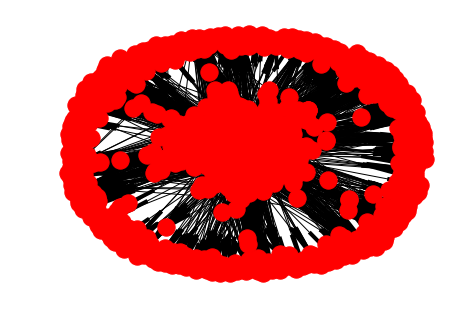

In [102]:
path = '/home/frank/Dropbox/school/Networks/data/pol_blog/polblogs.paj'
P1 = read_pajek(path, encoding='UTF-8')
nx.draw(P1)
plt.figure(figsize=(100,130))
plt.show()
plt.savefig("polblogs_networks.png")

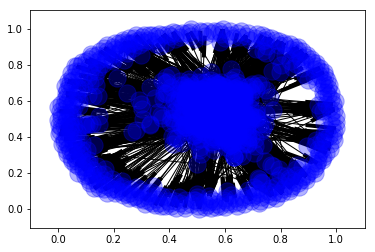

In [109]:
path = '/home/frank/Dropbox/school/Networks/data/pol_blog/polblogs.paj'
P1 = read_pajek(path, encoding='UTF-8')
#nx.draw(P1)
pos = nx.spring_layout(P1)
nx.draw_networkx_edges(G1, pos1)
nx.draw_networkx_nodes(G1, pos1,node_color='b', alpha = 0.3)
plt.figure(figsize=(100,130))
plt.show()
#plt.savefig("polblogs_networks.png")

In [ ]:
#import gml file, sepparate G1 (websites graph) and G2 (liberal vs conservative graph)
pol_blog = '/home/frank/Dropbox/school/Networks/data/pol_blog/polblogs.gml'
G1 = nx.read_gml(pol_blog)
pos1 = nx.spring_layout(G1)
nx.draw_networkx_edges(G1, pos1)
nx.draw_networkx_nodes(G1, pos1,node_color='b', alpha = 0.3)
#plt.title("Political blogs network", alpha = 0.3)
plt.plot()

In [95]:
P1.show()

AttributeError: 'MultiDiGraph' object has no attribute 'show'

In [96]:
nx.draw_random(P1)

In [106]:
#import gml file, sepparate G1 (websites graph) and G2 (liberal vs conservative graph)
pol_blog = '/home/frank/Dropbox/school/Networks/data/pol_blog/polblogs.gml'
G1 = nx.read_gml(pol_blog)
pos1 = nx.spring_layout(G1)
nx.draw_networkx_edges(G1, pos1)
nx.draw_networkx_nodes(G1, pos1,node_color='b', alpha = 0.3)
#plt.title("Political blogs network", alpha = 0.3)
plt.plot()

[]

In [83]:
pol_blog2 = '/home/frank/Dropbox/school/Networks/data/pol_blog/polblogs1.gml'
G2 = nx.read_gml(pol_blog2, label = str("source")) #  0 (left or liberal), 1 (right or conservative
pos2 = nx.spring_layout(G2)

In [84]:
pos2

{u'tsrightdominion.blogspot.com': array([ 0.52922064,  0.37413937], dtype=float32),
 u'rightrainbow.com': array([ 0.44308504,  0.40746579], dtype=float32),
 u'gregpalast.com': array([ 1.        ,  0.49808604], dtype=float32),
 u'younglibs.com': array([ 0.91244847,  0.77142584], dtype=float32),
 u'blotts.org/polilog': array([ 0.79815847,  0.08963642], dtype=float32),
 u'marylandpolitics.blogspot.com': array([ 0.9427858 ,  0.54307979], dtype=float32),
 u'blogitics.com': array([ 0.41513973,  0.93575758], dtype=float32),
 u'thesakeofargument.com': array([ 0.9526965 ,  0.34532246], dtype=float32),
 u'joebrent.blogspot.com': array([ 0.36794174,  0.48002094], dtype=float32),
 u'thesiliconmind.blogspot.com': array([ 0.95512366,  0.71360254], dtype=float32),
 u'kippsblog.com': array([ 0.5754416 ,  0.59980518], dtype=float32),
 u'progressivetrail.org/blog.shtml': array([ 0.06132879,  0.24913332], dtype=float32),
 u'randomjottings.net': array([ 0.44041234,  0.39837915], dtype=float32),
 u'rightvo

In [ ]:
read_gml(path[, label, destringizer])

In [61]:
pos

{u'tsrightdominion.blogspot.com': array([ 0.53452152,  0.58461928], dtype=float32),
 u'rightrainbow.com': array([ 0.53078622,  0.47917175], dtype=float32),
 u'gregpalast.com': array([ 0.15866922,  0.88470215], dtype=float32),
 u'younglibs.com': array([ 0.39669472,  0.03044114], dtype=float32),
 u'blotts.org/polilog': array([ 0.42181408,  0.02493429], dtype=float32),
 u'marylandpolitics.blogspot.com': array([ 0.62962997,  0.9872613 ], dtype=float32),
 u'blogitics.com': array([ 0.95880955,  0.41625276], dtype=float32),
 u'thesakeofargument.com': array([ 0.15089636,  0.85959798], dtype=float32),
 u'joebrent.blogspot.com': array([ 0.55711555,  0.49485043], dtype=float32),
 u'thesiliconmind.blogspot.com': array([ 0.86028051,  0.88491201], dtype=float32),
 u'kippsblog.com': array([ 0.42485601,  0.68323332], dtype=float32),
 u'progressivetrail.org/blog.shtml': array([ 0.16944186,  0.87043214], dtype=float32),
 u'randomjottings.net': array([ 0.53542978,  0.48491466], dtype=float32),
 u'rightvo

In [59]:
nx.draw(G)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
def er_graph(n,p,d=False):
    G = nx.erdos_renyi_graph(n,p,directed=d)
#    nx.draw(G)
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos,node_color='b', alpha = 0.3)
    nx.draw_networkx_edges(G, pos)
    plt.title("Erdos - Renyi random graph, prob = " + str(p))
    plt.plot(alpha=.005)
    # plt.savefig()
    # plt.show()

In [53]:
comp = girvan_newman(G)
tuple(c for c in next(comp))

({u'tsrightdominion.blogspot.com',
  u'rightrainbow.com',
  u'theblogwarrior.blogspot.com',
  u'pinkofeministhellcat.typepad.com/pinko_feminist_hellcat',
  u'newleftblogs.blogspot.com',
  u'kippsblog.com',
  u'jmbzine.com',
  u'jeremybrendan.blogspot.com',
  u'lashawnbarber.com',
  u'gregpalast.com',
  u'roxanne.typepad.com',
  u'jinkythecat.blogspot.com',
  u'johnkerrymustlose.com',
  u'robbernard.com',
  u'archpundit.com',
  u'liberalreview.blogspot.com',
  u'commonsenserunswild.typepad.com',
  u'younglibs.com',
  u'angryfinger.org',
  u'laughingwolf.net',
  u'daddypundit.blogspot.com',
  u'tomburka.com',
  u'cayankee.blogs.com',
  u'digitaljay.blogspot.com',
  u'politicalvicesquad.blogspot.com',
  u'rabner.blogspot.com',
  u'truebluegal.blogspot.com',
  u'pejmanesque.com',
  u'cleancutkid.com',
  u'myleftbrain.com',
  u'rightonred.net',
  u'one38.org',
  u'claycalhoun.com',
  u'blogspirator.blogspot.com',
  u'redstatealliance.blogspot.com',
  u'blogslut.com',
  u'allanjenkins.typepa

In [51]:
type(comp.next())

tuple

In [44]:
G = nx.path_graph(10)
comp = girvan_newman(G)

In [45]:
comp

<generator object girvan_newman at 0x7f2c2ee9cd70>

In [ ]:
import numpy as np
from time import clock
from scipy.linalg import eigh as largest_eigh
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh

np.set_printoptions(suppress=True)
np.random.seed(0)
N=5000
k=10
X = np.random.random((N,N)) - 0.5
X = np.dot(X, X.T) #create a symmetric matrix

# Benchmark the dense routine
start = clock()
evals_large, evecs_large = largest_eigh(X, eigvals=(N-k,N-1))
elapsed = (clock() - start)
print "eigh elapsed time: ", elapsed

# Benchmark the sparse routine
start = clock()
evals_large_sparse, evecs_large_sparse = largest_eigsh(X, k, which='LM')
elapsed = (clock() - start)
print "eigsh elapsed time: ", elapsed